In [5]:
# general
import numpy as np
from numpy.random import PCG64, SeedSequence
import pandas as pd
import verde as vd
import harmonica as hm
from scipy import interpolate
import xarray as xr
import cmocean
from cmcrameri import cm
import geopandas as gpd
from skgstat import models
import gstatsim as gsm
import cartopy.crs as ccrs
from scipy.interpolate import RBFInterpolator
from scipy.stats import qmc

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib import animation

# io
from tqdm.auto import tqdm
import os
from pathlib import Path
import time
import numbers

import sys
sys.path.append('../src')

from gstatsim_custom import *

In [6]:
ds = xr.load_dataset('test_data.nc')
ds

<xarray.Dataset> Size: 4MB
Dimensions:                 (x: 200, y: 300)
Coordinates:
  * x                       (x) float32 800B -1.25e+06 -1.249e+06 ... -1.15e+06
  * y                       (y) float32 1kB -7.502e+05 -7.508e+05 ... -8.998e+05
Data variables: (12/14)
    surface_topography      (y, x) float32 240kB 1.985e+03 ... 2.275e+03
    bed_uncertainty         (y, x) float32 240kB 153.0 151.0 ... 167.0 163.0
    bed_topography          (y, x) float32 240kB 15.0 61.0 ... -353.0 -319.0
    mask                    (y, x) float32 240kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    ice_thickness           (y, x) float32 240kB 1.97e+03 ... 2.594e+03
    thickness_survey_count  (y, x) float32 240kB nan nan nan nan ... nan nan nan
    ...                      ...
    geoid                   (y, x) float64 480kB -35.0 -35.0 ... -38.0 -38.0
    bed_ell                 (y, x) float64 480kB -20.0 26.0 ... -391.0 -357.0
    surface_ell             (y, x) float64 480kB 1.95e+03 ... 2.237e+03
    thick_cond              (y, x) float64 480kB nan nan nan nan ... nan nan nan
    vx                      (y, x) float32 240kB -5.393 -3.659 ... 2.892 2.983
    vy                      (y, x) float32 240kB 14.38 14.35 ... 5.464 5.648
Attributes: (12/26)
    crs:                    EPSG:3031
    title:                  BEDMAP3 - Ice thickness, bed and surface elevatio...
    summary:                We present here Bedmap3, the latest suite of grid...
    keywords:               Antarctica,BEDMAP,Elevation,Ice thickness
    Conventions:            ACDD-1.3, CF-1.8
    citation:               Pritchard, H., Fretwell, P., Fremand, A., Bodart,...
    ...                     ...
    time_coverage_end:      2024-11-01
    geospatial_lon_min:     -180
    geospatial_lon_max:     180
    geospatial_lat_min:     -90
    geospatial_lat_max:     -60
    geospatial_bounds_crs:  EPSG:4326

In [7]:
bed_cond = ds.surface_topography.values - ds.thick_cond.values
xx, yy = np.meshgrid(ds.x, ds.y)

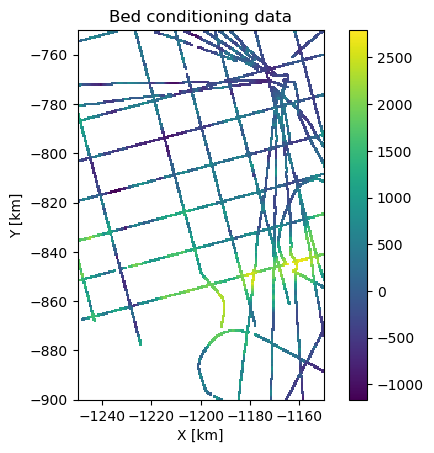

In [8]:
plt.pcolormesh(ds.x/1000, ds.y/1000, bed_cond)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Bed conditioning data')
plt.colorbar()
plt.show()

In [9]:
cond_msk = ~np.isnan(bed_cond)
x_cond = xx[cond_msk]
y_cond = yy[cond_msk]
data_cond = bed_cond[cond_msk]

bed_norm, nst_trans = gaussian_transformation(bed_cond, cond_msk)
df_grid = pd.DataFrame({'X' : x_cond, 'Y' : y_cond, 'residual' : data_cond.squeeze(), 'NormZ' : bed_norm[cond_msk]})

In [10]:
vgrams, experimental, bins = do_variograms(xx, yy, bed_cond, maxlag=50e3, n_lags=20, downsample=10)

In [11]:
# evaluate models
xi =np.linspace(0, bins[-1], 100) 

y_exp = models.exponential(xi, *vgrams['exponential'])
y_gauss = models.gaussian(xi, *vgrams['gaussian'])
y_sph = models.spherical(xi, *vgrams['spherical'])
y_matern = models.matern(xi, *vgrams['matern'])

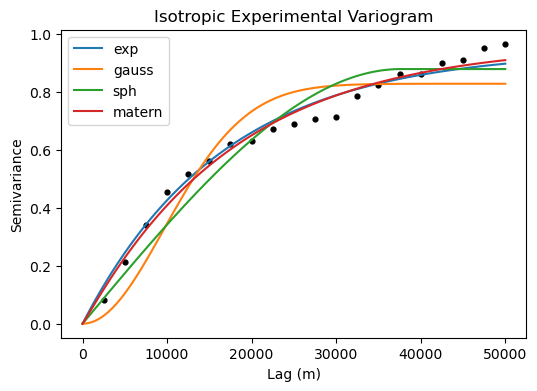

In [12]:
plt.figure(figsize=(6,4))
plt.scatter(bins, experimental, s=12, c='k')
plt.plot(xi, y_exp, label='exp')
plt.plot(xi, y_gauss, label='gauss')
plt.plot(xi, y_sph, label='sph')
plt.plot(xi, y_matern, label='matern')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.legend()
plt.show()

In [12]:
vgrams['matern']

[np.float64(49999.99999999999),
 np.float64(0.9687501089176487),
 np.float64(0.5269854349970702),
 0]

In [13]:
rng = np.random.default_rng(0)

parameters = vgrams['matern']

# set variogram parameters
nugget = parameters[-1]
major_range = parameters[0]
minor_range = parameters[0]
sill = parameters[1]
smoothness = parameters[2]
nugget = parameters[-1]
azimuth = 0

# save variogram parameters as a list
vario = [azimuth, nugget, major_range, minor_range, sill, 'matern', smoothness]

k = 20
rad = 300e3

pred_grid = np.stack([xx.flatten(), yy.flatten()]).T
sim = gsm.Interpolation.okrige_sgs(pred_grid, df_grid, 'X', 'Y', 'NormZ', k, vario, rad, quiet=False, seed=rng)
sim_trans = nst_trans.inverse_transform(sim.reshape(-1,1)).squeeze()

100%|██████████| 60000/60000 [08:25<00:00, 118.66it/s]


In [14]:
bed_gsm = sim_trans.reshape(xx.shape)

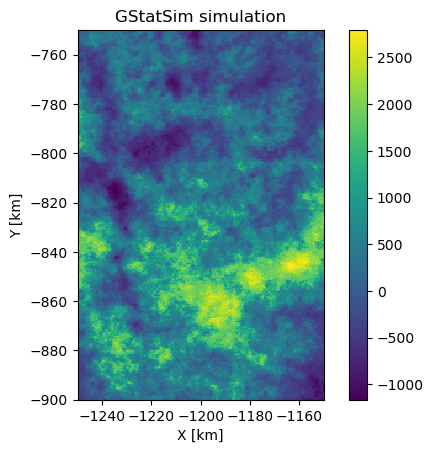

In [15]:
plt.pcolormesh(ds.x/1000, ds.y/1000, bed_gsm)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('GStatSim simulation')
plt.colorbar()
plt.show()

# New GStatSim variant is faster

In [17]:
vario = {
    'azimuth' : azimuth,
    'nugget' : nugget,
    'major_range' : major_range,
    'minor_range' : minor_range,
    'sill' : sill,
    'smoothness' : smoothness,
    'vtype' : 'matern',
}

bed_newsim = sgs(xx, yy, bed_cond, vario, rad, k, seed=rng)

  0%|          | 0/60000 [00:00<?, ?it/s]

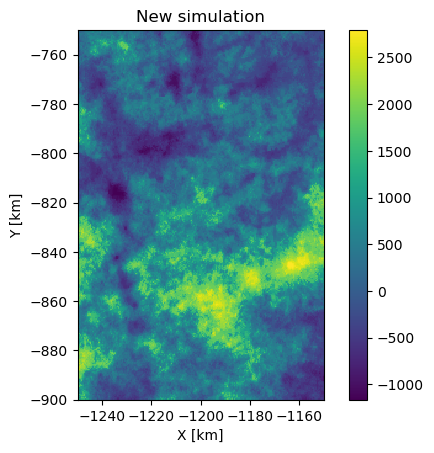

In [18]:
plt.pcolormesh(ds.x/1000, ds.y/1000, bed_newsim)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('New simulation')
plt.colorbar()
plt.show()

# We can have nonstationary variogram parameters

In [19]:
bounds = [-1.25e6, -0.9e6, -1.15e6, -0.75e6]
l_bounds = bounds[:2]
u_bounds = bounds[2:]

sampler = qmc.LatinHypercube(d=2, optimization="random-cd")
sample = sampler.random(n=50)
rescaled = qmc.scale(sample, l_bounds, u_bounds)

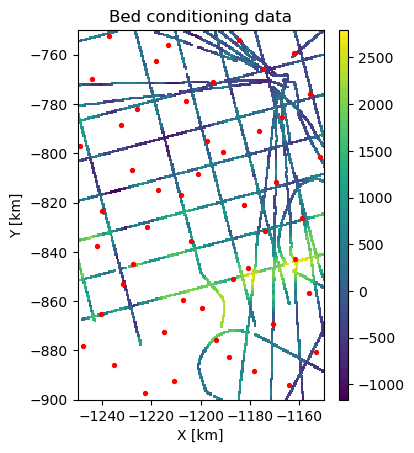

In [82]:
im = plt.pcolormesh(ds.x/1000, ds.y/1000, bed_cond)
plt.scatter(rescaled[:,0]/1000, rescaled[:,1]/1000, s=8, color='r')
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Bed conditioning data')
plt.colorbar(im, pad=0.03, aspect=40)
plt.show()

In [34]:
mindist = 100e3
mindata = 500

n_points = rescaled.shape[0]

var = np.zeros(n_points)
ranges = np.zeros(n_points)
range_primary = np.zeros(n_points)
range_secondary = np.zeros(n_points
sills = np.zeros(n_points)
smooths = np.zeros(n_points)

bed_values = bed_cond[cond_msk]
coordinates = (x_cond, y_cond)
coordinates_npy = np.array(coordinates).T

for i in tqdm(range(n_points)):
    # get cond data within distance of point
    dist = mindist
    n_cond = 0
    while n_cond < mindata:
        dist_msk = vd.distance_mask(rescaled[i], dist, coordinates)
        n_cond = bed_values[dist_msk].size
        dist += 10e3
        
    var[i] = np.var(bed_values[dist_msk])

    data_cond = bed_values[dist_msk].reshape(-1,1)
    coords = coordinates_npy[dist_msk]

    inds = rng.integers(0, data_cond.shape[0]-1, mindata)
    data_cond = data_cond[inds]
    coords = coords[inds]

    # normal score transformation
    nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data_cond)
    norm_data = nst_trans.transform(data_cond).squeeze()

    # compute experimental (isotropic) variogram
    V = skg.Variogram(coords, norm_data, bin_func='even', n_lags=20, 
                   maxlag=70e3, normalize=False)
    V.model = 'matern'

    ranges[i] = V.parameters[0]
    sills[i] = V.parameters[1]
    smooths[i] = V.parameters[2]

  0%|          | 0/50 [00:00<?, ?it/s]

In [35]:
smoothing = 0

interp = RBFInterpolator(rescaled, var, smoothing=smoothing)
interp_vars = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)

interp = RBFInterpolator(rescaled, ranges, smoothing=smoothing)
interp_ranges = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)

interp = RBFInterpolator(rescaled, sills, smoothing=smoothing)
interp_sills = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)

interp = RBFInterpolator(rescaled, smooths, smoothing=smoothing)
interp_smooths = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)
interp_smooths = np.where(interp_smooths < 0, 0.1, interp_smooths)
interp_smooths = np.where(interp_smooths > 20, 20, interp_smooths)

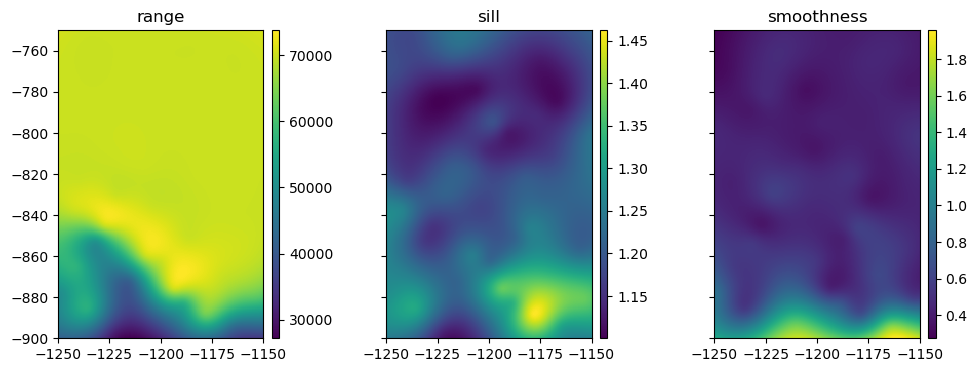

In [36]:
plots = [interp_ranges, interp_sills, interp_smooths]
titles = ['range', 'sill', 'smoothness']

fig, axs = plt.subplots(1, 3, figsize=(12,4), sharey=True)

for p, ax, title in zip(plots, axs, titles):
    im = ax.pcolormesh(ds.x/1000, ds.y/1000, p)
    ax.axis('scaled')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
plt.show()

In [42]:
vario = {
    'azimuth' : 0,
    'nugget' : 0,
    'major_range' : interp_ranges,
    'minor_range' : interp_ranges,
    'sill' : interp_sills,
    'smoothness' : interp_smooths,
    'vtype' : 'matern'
}

sim_nonstat = sgs(xx, yy, bed_cond, vario, rad, k, seed=rng)

  0%|          | 0/60000 [00:00<?, ?it/s]

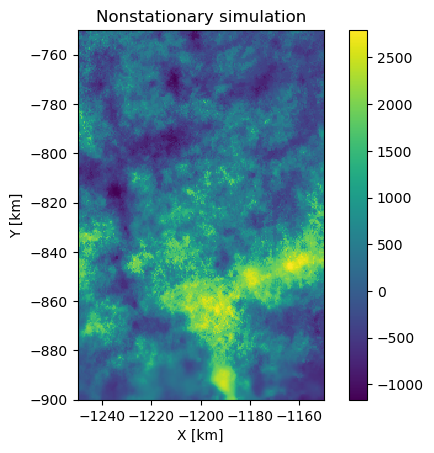

In [44]:
plt.pcolormesh(ds.x/1000, ds.y/1000, sim_nonstat)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Nonstationary simulation')
plt.colorbar()
plt.show()

# Including anisotropy using the azimuth

In [50]:
ds_coarse = ds.coarsen(x=20, y=20, boundary='trim').mean()

In [48]:
def rescale(m, a, b):
    return (m-np.min(m))/(np.max(m)-np.min(m))*(b-a)+a

vel_mag = np.sqrt(ds.vx.values**2+ds.vy.values**2)
vel_angle = np.arctan2(ds.vy.values, ds.vx.values)*180/np.pi
rescale_mag = rescale(vel_mag, 1, 2)

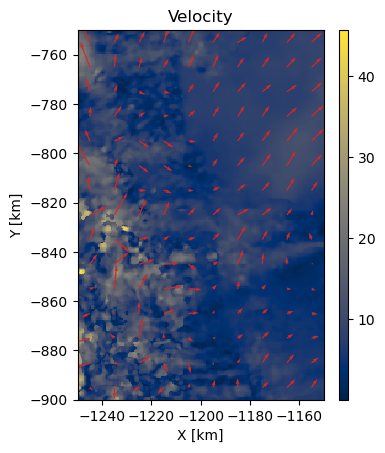

In [56]:
im = plt.pcolormesh(ds.x/1000, ds.y/1000, vel_mag, cmap='cividis')
plt.quiver(ds_coarse.x/1000, ds_coarse.y/1000, ds_coarse.vx, ds_coarse.vy, color='tab:red')
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Velocity')
plt.colorbar(im, pad=0.03, aspect=40)
plt.show()

In [107]:
import warnings

range_primary = np.zeros(n_points)
range_secondary = np.zeros(n_points)
azims = np.zeros(n_points)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for i in tqdm(range(n_points)):
        # get cond data within distance of point
        dist = mindist
        n_cond = 0
        while n_cond < mindata:
            dist_msk = vd.distance_mask(rescaled[i], dist, coordinates)
            n_cond = bed_values[dist_msk].size
            dist += 10e3
    
        data_cond = bed_values[dist_msk].reshape(-1,1)
        coords = coordinates_npy[dist_msk]
    
        inds = rng.integers(0, data_cond.shape[0]-1, mindata)
        data_cond = data_cond[inds]
        coords = coords[inds]
    
        # normal score transformation
        nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data_cond)
        norm_data = nst_trans.transform(data_cond).squeeze()
    
        # find nearest grid cell
        xind = np.argmin(np.abs(ds.x.values-rescaled[i,0]))
        yind = np.argmin(np.abs(ds.y.values-rescaled[i,1]))
        azim = vel_angle[yind,xind]
        azims[i] = azim
    
        V_primary = skg.DirectionalVariogram(coords, norm_data, bin_fun="even", n_lags=20, 
                                          maxlag=70e3, normalize=False, azimuth=azim, tolerance=15)
        V_primary.model = 'matern'

        if azim < 90:
            second_azim = azim + 90
        else:
            second_azim = azim - 90
        
        V_secondary = skg.DirectionalVariogram(coords, norm_data, bin_func="even", n_lags=20, 
                                          maxlag=70e3, normalize=False, azimuth=second_azim, tolerance=15)
        V_secondary.model = 'matern'
    
        range_primary[i] = V_primary.parameters[0]
        range_secondary[i] = V_secondary.parameters[0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [108]:
smoothing = 0

interp = RBFInterpolator(rescaled, range_primary, smoothing=smoothing)
interp_primary_ranges = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)

interp = RBFInterpolator(rescaled, range_secondary, smoothing=smoothing)
interp_secondary_ranges = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)

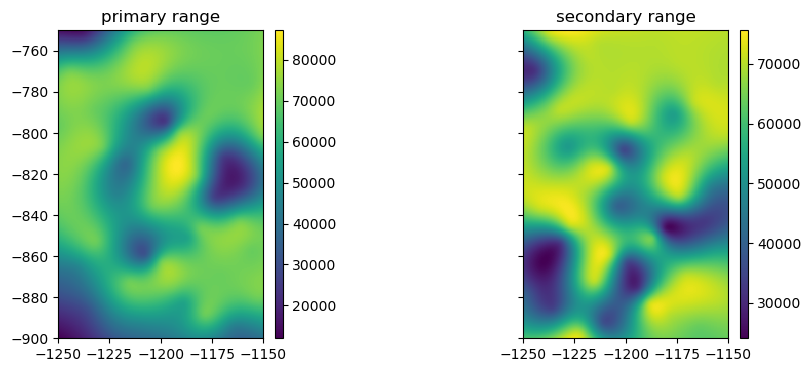

In [109]:
fig, axs = plt.subplots(1, 2, figsize=(9,4), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, interp_primary_ranges)
ax.axis('scaled')
ax.set_title('primary range')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, interp_secondary_ranges)
ax.axis('scaled')
ax.set_title('secondary range')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

plt.show()

In [110]:
vario = {
    'azimuth' : vel_angle,
    'nugget' : 0,
    'major_range' : interp_primary_ranges,
    'minor_range' : interp_secondary_ranges,
    'sill' : interp_sills,
    'smoothness' : interp_smooths,
    'vtype' : 'matern'
}

sim_aniso = sgs(xx, yy, bed_cond, vario, rad, k, seed=rng)

  0%|          | 0/60000 [00:00<?, ?it/s]

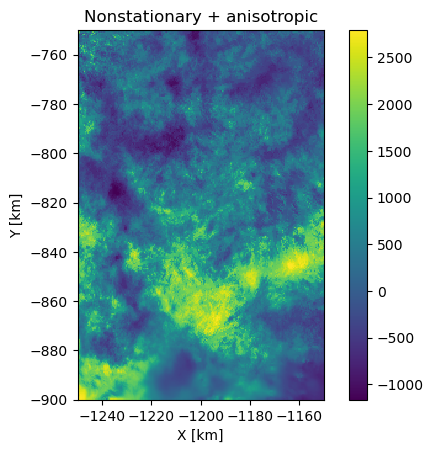

In [111]:
plt.pcolormesh(ds.x/1000, ds.y/1000, sim_aniso)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Nonstationary + anisotropic')
plt.colorbar()
plt.show()

# Simulate only where you want to with sim_mask

In [13]:
k = 20
rad = 300e3

In [14]:
vario = {
    'azimuth' : vel_angle,
    'nugget' : 0,
    'major_range' : interp_ranges,
    'minor_range' : interp_ranges/rescale_mag,
    'sill' : interp_sills,
    'smoothness' : interp_smooths,
    'vtype' : 'matern'
}

sim_mask = np.full(xx.shape, False)
sim_mask[100:200,50:150] = True

sim_partial = sgs(xx, yy, bed_cond, vario, rad, k, sim_mask=sim_mask, seed=rng)

NameError: name 'vel_angle' is not defined

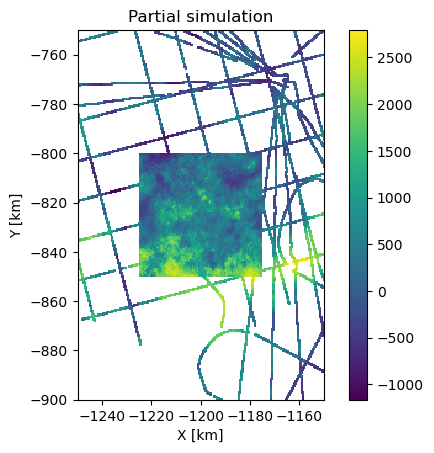

In [66]:
plt.pcolormesh(ds.x/1000, ds.y/1000, sim_partial)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Partial simulation')
plt.colorbar()
plt.show()

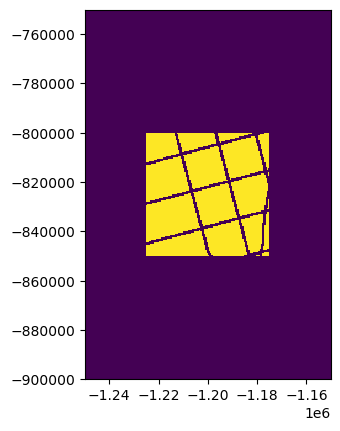

In [15]:
sim_mask = np.full(xx.shape, False)
sim_mask[100:200,50:150] = True
tmp = ~cond_msk & sim_mask

plt.pcolormesh(ds.x, ds.y, tmp)
plt.axis('scaled')
plt.show()